In [1]:
include("model.jl")

para = [2.83 0.78 1.80 0.63 0.42 3.30 0.52 0.77 0.98 0.88 0.22 0.71 0.31]
m = new_model()
@time solve(m,para)

  1.321947 seconds (5.31 M allocations: 243.486 MiB, 6.97% gc time)


true

1.45


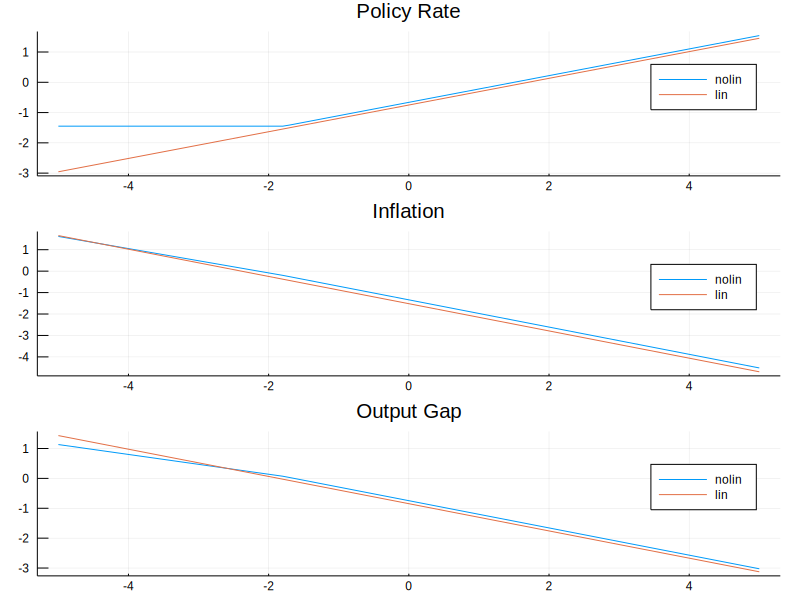

In [2]:
using Plots

include("linsol.jl")

T1,T0 = model_solution(para)

rA      = para[5]
piA     = para[6]
gammaQ  = para[7]
rho_R   = para[8]
rho_g   = para[9]
rho_z   = para[10]
sigma_R = para[11]
sigma_g = para[12]
sigma_z = para[13]

bet  = 1/(1+rA/400)
rstar = gammaQ+piA/4+rA/4

# set bounds
rnmin = -m.pctrn
rnmax = m.pctrn
gmin = -m.mg*sigma_g/sqrt(1-rho_g^2)
gmax = m.mg*sigma_g/sqrt(1-rho_g^2)
zmin = -m.mz*sigma_z/sqrt(1-rho_z^2)
zmax = m.mz*sigma_z/sqrt(1-rho_z^2)
rmin = -m.mr*sigma_R
rmax = m.mr*sigma_R

rngrid = collect(LinRange(rnmin,rnmax,101))
ggrid = collect(LinRange(gmin,gmax,101))
zgrid = collect(LinRange(zmin,zmax,101))
rgrid = collect(LinRange(rmin,rmax,101))

rnvec_lin = zeros(101)
pivec_lin = zeros(101)
yvec_lin  = zeros(101)
cvec_lin  = zeros(101)
rnvec_nolin = zeros(101)
pivec_nolin = zeros(101)
yvec_nolin  = zeros(101)
cvec_nolin  = zeros(101)

for i = 1:101
    
    rnpast = rngrid[i]
    gnow = 0 #gmax
    znow = zmin
    rnow = 0 #rmin

    # for the linearized model
    endogvarm = zeros(8)
    endogvarm[3] = rnpast
    shocks = zeros(3)
    shocks[1] = znow
    shocks[2] = gnow
    shocks[3] = rnow
    endogvar = T1*endogvarm + T0*shocks
    
    rnvec_lin[i] = endogvar[3]
    pivec_lin[i] = endogvar[2]
    yvec_lin[i] = endogvar[1]    
    
    # for the quasi-linear model
    endogvarm = [rnpast 0 0 0 0 0 0 gnow znow rnow]
    shocks = zeros(3)
#     endogvarm = [rnpast 0 0 0 0 0 0 0 0 0]
#     shocks = [gnow znow rnow]
    endogvar = decr(endogvarm,shocks,para,m.slopecon,m.coeffcn,m.coeffpn,m.coeffcb,m.coeffpb,m.np,m.ns,m.zlbflag)
    
    rnvec_nolin[i] = endogvar[5]
    pivec_nolin[i] = endogvar[3]
    yvec_nolin[i] = endogvar[4]
    cvec_nolin[i] = endogvar[2]
    
end

plot(
    plot(rngrid,[rnvec_nolin rnvec_lin],title="Policy Rate"),
    plot(rngrid,[pivec_nolin pivec_lin],title="Inflation"),
    plot(rngrid,[yvec_nolin yvec_lin],title="Output Gap"),
    layout=(3,1),size=(800,600),label=["nolin" "lin"]
)
